# Tutorial: Fine-tuning an Embedding Model with Evaluation and Histogram Analysis

In this tutorial, we will:

- Fine-tune a pre-trained SentenceTransformer model on a custom dataset of sentence pairs.
- Compare cosine similarity distributions before and after fine-tuning using histogram plots.
- Evaluate the model using accuracy, confusion matrix, precision, recall, and F1 score.
- Demonstrate the use of different loss functions (e.g. **ContrastiveLoss**).

Let's get started!

In [35]:
# Step 1: Import the required libraries
import torch
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, InputExample, losses

print('All libraries imported successfully!')

All libraries imported successfully!


## Step 2: Data Preparation

We create a sample dataset with sentence pairs and a binary label indicating whether the sentences are similar (1) or not (0).

The CSV file located on "data/data_for_embedding/final/embedding_dataset_question_table_description_label.csv" on GitHub Repository


In [21]:
df = pd.read_csv('/content/embedding_dataset_question_table_description_label.csv')
df.head()

,Question,Table_description,label
0,Which schools require high school grades,This table contains data for branch campus loc...,1
1,Which schools require high school grades,This table contains the graduation rate status...,1
2,Which schools require high school grades,This table contains information about the unde...,1
3,Which schools require high school grades,This table contains the number of programs off...,1
4,Which schools require high school grades,This table contains directory information for ...,0


In [24]:
# Convert DataFrame rows to InputExample objects required by SentenceTransformer
train_examples = []
for _, row in df.iterrows():
    train_examples.append(InputExample(texts=[row['Question'], row['Table_description']], label=float(row['label'])))

print('\nNumber of training examples:', len(train_examples))


Number of training examples: 1086


## Step 3: Initial Cosine Similarity Evaluation (Before Fine-tuning)

Before fine-tuning, we compute the cosine similarity between the embeddings of each sentence pair and visualize the distribution with a histogram.

In [26]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for sentence1 and sentence2
embeddings1 = model.encode(df["Question"].tolist())
embeddings2 = model.encode(df["Table_description"].tolist())

# Compute cosine similarity for each pair
cosine_similarities = []
for emb1, emb2 in zip(embeddings1, embeddings2):
    sim = cosine_similarity([emb1], [emb2])[0][0]
    cosine_similarities.append(sim)

# Add cosine similarity scores to the dataframe
df['cosine_similarity_before'] = cosine_similarities
print('Cosine similarities before fine-tuning:')
df[['Question', 'Table_description', 'cosine_similarity_before']]

Cosine similarities before fine-tuning:


,Question,Table_description,cosine_similarity_before
0,Which schools require high school grades,This table contains data for branch campus loc...,0.183993
1,Which schools require high school grades,This table contains the graduation rate status...,0.292432
2,Which schools require high school grades,This table contains information about the unde...,0.386880
3,Which schools require high school grades,This table contains the number of programs off...,0.312553
4,Which schools require high school grades,This table contains directory information for ...,0.226394
...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,0.487913
1082,How many universites have graduate offerings,This table contains information about the unde...,0.265634
1083,How many universites have graduate offerings,This table contains the number of programs off...,0.345595
1084,How many universites have graduate offerings,This table contains directory information for ...,0.326346


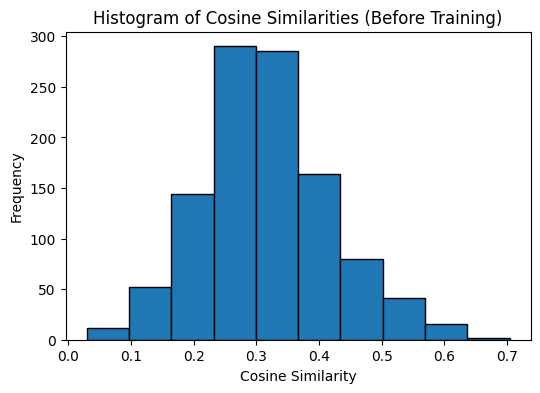

In [27]:
# Plot histogram of cosine similarity scores before training
plt.figure(figsize=(6,4))
plt.hist(cosine_similarities, bins=10, edgecolor='black')
plt.title('Histogram of Cosine Similarities (Before Training)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

## Step 4: Model Definition and Loss Setup

We load the same pre-trained model as our starting point. In this tutorial, we use **ContrastiveLoss** as our loss function, which is well-suited when you have pairs of sentences with a binary similarity label. 

>*Note:* If you prefer, you can switch to another loss such as `CosineSimilarityLoss` by modifying the loss function below.

In [28]:
# Load the model (if not already loaded) and define the loss function
model = SentenceTransformer('all-MiniLM-L6-v2')

# Choose the loss function. Here we use ContrastiveLoss.
loss = losses.ContrastiveLoss(model=model)

# Alternatively, you can use CosineSimilarityLoss by uncommenting the next line
# loss = losses.CosineSimilarityLoss(model=model)

# Create a DataLoader for our training examples
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)

print('Model and training components are set up with ContrastiveLoss.')

Model and training components are set up with ContrastiveLoss.


## Step 5: Fine-tuning the Model

Now we fine-tune the model using our custom dataset. For demonstration purposes, we set a small number of epochs. In a production scenario, consider using a larger dataset and more training epochs.

In [30]:
# Fine-tune the model
num_epochs = 1  

print('Starting fine-tuning...')
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=10,
    show_progress_bar=True
)
print('Fine-tuning completed!')

Starting fine-tuning...


Step,Training Loss
500,0.015700


Fine-tuning completed!


## Step 6: Post-training Evaluation and Histogram Analysis

After fine-tuning, we recompute the cosine similarities for each sentence pair. We then:

- Plot a histogram of the updated cosine similarity scores.
- Define a prediction threshold (e.g. 0.9) to convert cosine similarities into binary labels.
- Compute evaluation metrics such as accuracy, confusion matrix, precision, recall, and F1 score.

In [31]:
# Compute embeddings with the fine-tuned model
embeddings1_after = model.encode(df["Question"].tolist())
embeddings2_after = model.encode(df["Table_description"].tolist())

cosine_similarities_after = []
for emb1, emb2 in zip(embeddings1_after, embeddings2_after):
    sim = cosine_similarity([emb1], [emb2])[0][0]
    cosine_similarities_after.append(sim)

# Add post-training cosine similarity scores to the dataframe
df['cosine_similarity_after'] = cosine_similarities_after
print('Cosine similarities after fine-tuning:')
df[['Question', 'Table_description', 'cosine_similarity_after']]


Cosine similarities after fine-tuning:


,Question,Table_description,cosine_similarity_after
0,Which schools require high school grades,This table contains data for branch campus loc...,0.949610
1,Which schools require high school grades,This table contains the graduation rate status...,0.953320
2,Which schools require high school grades,This table contains information about the unde...,0.959573
3,Which schools require high school grades,This table contains the number of programs off...,0.858712
4,Which schools require high school grades,This table contains directory information for ...,0.591443
...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,0.972756
1082,How many universites have graduate offerings,This table contains information about the unde...,0.968647
1083,How many universites have graduate offerings,This table contains the number of programs off...,0.867262
1084,How many universites have graduate offerings,This table contains directory information for ...,0.657458


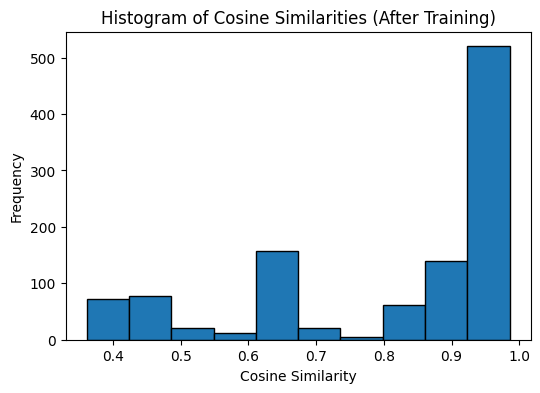

In [32]:

# Plot histogram of cosine similarity scores after training
plt.figure(figsize=(6,4))
plt.hist(cosine_similarities_after, bins=10, edgecolor='black')
plt.title('Histogram of Cosine Similarities (After Training)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


Accuracy: 78.73%
Precision: 95.40%
Recall: 71.55%
F1 Score: 81.77%


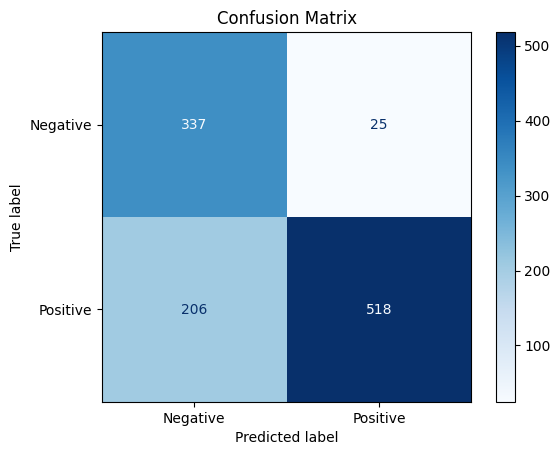

In [36]:
# Define a threshold to convert cosine similarity into a binary prediction
threshold = 0.9
df['predicted_label'] = df['cosine_similarity_after'].apply(lambda x: 1 if x > threshold else 0)

# Calculate evaluation metrics
acc = accuracy_score(df['label'], df['predicted_label'])
prec = precision_score(df['label'], df['predicted_label'])
rec = recall_score(df['label'], df['predicted_label'])
f1 = f1_score(df['label'], df['predicted_label'])

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# Compute the confusion matrix directly
cm = confusion_matrix(df['label'], df['predicted_label'])

# Create the display object with the confusion matrix and desired display labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix with a chosen color map (optional)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# how to compute accuracy at different K values for the model.
## The evaluation measures how well the model retrieves relevant tables (where label == 1) for each question based on the top K predicted tables.

In [42]:
import pandas as pd

# Example DataFrame (for testing purposes)
# Uncomment and modify the following code to load your actual DataFrame.
# data = {
#     'Question': ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3'],
#     'Table_description': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'],
#     'label': [1, 0, 0, 1, 0, 0, 1, 0, 0]
# }
# df = pd.DataFrame(data)

def calculate_accuracy_at_k(df: pd.DataFrame, k_values: list) -> list:
    """
    Calculate accuracy at various top-K values for each question.

    For each unique question in the DataFrame, the function computes the accuracy
    at different K values based on the number of relevant tables (where label == 1)
    found in the top K predictions.

    Parameters:
        df (pd.DataFrame): DataFrame with columns 'Question', 'label', and 'Table_description'.
                           It is assumed that rows for a given question are sorted by predicted
                           cosine similarity (from highest to lowest).
        k_values (list): List of integer K values at which to calculate the accuracy.

    Returns:
        results (list): A list of dictionaries. Each dictionary contains:
            - 'question': The question text.
            - 'relevant_table': Set of tables with label == 1.
            - 'accuracy_at_k': Dictionary mapping each K value to its corresponding accuracy.
    """
    results = []
    
    # Iterate over each unique question
    for question in df['Question'].unique():
        question_df = df[df['Question'] == question]
        
        # Get the set of relevant tables (ground truth where label == 1)
        relevant_tables = set(question_df.loc[question_df['label'] == 1, 'Table_description'])
        
        accuracy_at_k = {}
        # Compute accuracy for each K value
        for k in k_values:
            # Get the top K tables (assuming the DataFrame is sorted by predicted score)
            top_k_tables = set(question_df.head(k)['Table_description'])
            # Count how many of the top K are relevant
            correct_predictions = len(relevant_tables.intersection(top_k_tables))
            total_relevant = len(relevant_tables)
            # Avoid division by zero if there are no relevant tables
            accuracy = correct_predictions / total_relevant if total_relevant > 0 else 0
            accuracy_at_k[k] = accuracy
        
        results.append({
            'question': question,
            'relevant_table': relevant_tables,
            'accuracy_at_k': accuracy_at_k
        })
    
    return results

# Define K values for evaluation
k_values = [1, 2, 3, 4, 5, 6]

# Calculate accuracy for each question
results = calculate_accuracy_at_k(df, k_values)

# Aggregate and average the accuracy across all questions for each K value
total_accuracy_at_k = {k: 0 for k in k_values}
for result in results:
    for k in k_values:
        total_accuracy_at_k[k] += result['accuracy_at_k'][k]

# Average the accuracy over all questions
num_questions = len(df['Question'].unique())
for k in k_values:
    total_accuracy_at_k[k] /= num_questions


accuracy_df = pd.DataFrame({
    'K': list(total_accuracy_at_k.keys()),
    'Accuracy (%)': [acc * 100 for acc in total_accuracy_at_k.values()]
})
accuracy_df


,K,Accuracy (%)
0,1,25.0
1,2,50.0
2,3,75.0
3,4,100.0
4,5,100.0
5,6,100.0


## Step 7: Saving and Loading the Fine-tuned Model

After fine-tuning and evaluation, save the model so that it can be reloaded later without retraining.

In [34]:
# Save the fine-tuned model
output_path = 'fine_tuned_embedding_model'
model.save(output_path)
print(f'Model saved to {output_path}')

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Model saved to fine_tuned_embedding_model


# Conclusion

In this tutorial, we have:

- Prepared a dataset of sentence pairs and labels.
- Evaluated the initial model using cosine similarity histograms.
- Fine-tuned a SentenceTransformer model using ContrastiveLoss.
- Performed post-training evaluation with histogram analysis and computed key evaluation metrics.

Feel free to modify the dataset, experiment with different loss functions, or adjust the training parameters for your specific use case. Happy fine-tuning!